### Imports

In [217]:
from XRDXRFutils import DatabaseXRD, DataXRD, SpectraXRD, GaussNewton, PhaseList, PhaseMap, PhaseSearch, PhaseMapSave

import os
import pickle


from joblib import Parallel, delayed
import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace,concatenate,sqrt,log,histogram
from matplotlib.pyplot import imshow,subplots,plot,xlim,ylim,xlabel,ylabel,cm,title,scatter,colorbar,figure
from sklearn.cluster import KMeans,MiniBatchKMeans

from PIL import Image

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

#### Define Paths

In [2]:
path_xrd = '/home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/'
path_database = '/home/shared/DatabaseXRD'

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

#### Spectra parameters

In [3]:
min_theta = 20
max_theta = 53
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)

#### Read XRD Data

from xrd.h5

In [4]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').save_h5(path_xrd + 'xrd.h5')

Loading: /home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/xrd.h5


#### Display datacube

This is only to check. Shows sum across the spectra dimension.

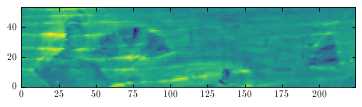

In [251]:
im = imshow(data.data.sum(axis=2)[::-1,::-1])

For the large datacubes the datasize can be easily reduced using [::n,::n]
where every $n$th pixel is taken

Notes:
Please keep in mind that this rewrites the original dataset so to return the datacube must be reloaded

In [7]:
data.data = data.data[::3,::3]

Display reduced datacube

when $n=3$ every third pixel is taken 

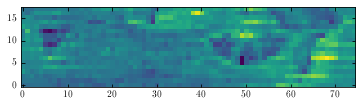

In [8]:
imshow(data.data.sum(axis=2))

#### Print calibration parameters

In [6]:
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

a: -1327.1 s: 2729.8 beta: 43.202


#### Read database

In [7]:
database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:',len(database))

Phases in database: 117


#### Define Phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [8]:
lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]

orpiment = database['Orpiment'][0]
cuprorivaite = database['Cuprorivaite'][0]

### Autocalibration and Phase Search

Takes 'data' and a list of phases to search for. Searches for phases iterating both $a$ and $s$.

In [9]:
phases_a_s = PhaseList([hematite,orpiment,cuprorivaite])

PhaseMap construct a data structures for the minimization.

In [10]:
%%time
pm = PhaseMap(data, phases_a_s,
              min_theta = min_theta,
              max_theta = max_theta,
              min_intensity = min_intensity,
              first_n_peaks = first_n_peaks)

CPU times: user 40.5 s, sys: 3.9 s, total: 44.4 s
Wall time: 50.4 s


#### Autocalibration and Search
Iterates $a$ $s$ and $\gamma$

In [11]:
%%time
pm.search()

CPU times: user 1min 46s, sys: 13.2 s, total: 2min
Wall time: 2min 13s


#### Display loss for each phase

In [218]:
loss = pm.fit_error()
opt = pm.opt()
a = opt[...,0]
s = opt[...,1]

Text(0.5, 1.0, 'Histogram of $a$')

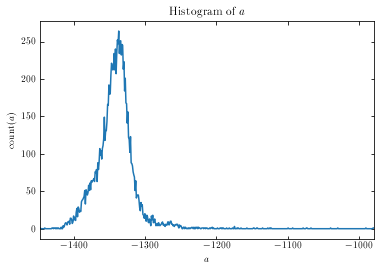

In [219]:
h,b = histogram(a,bins=512)
plot(b[:-1],h)
xlim(b[0],b[-1])
xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

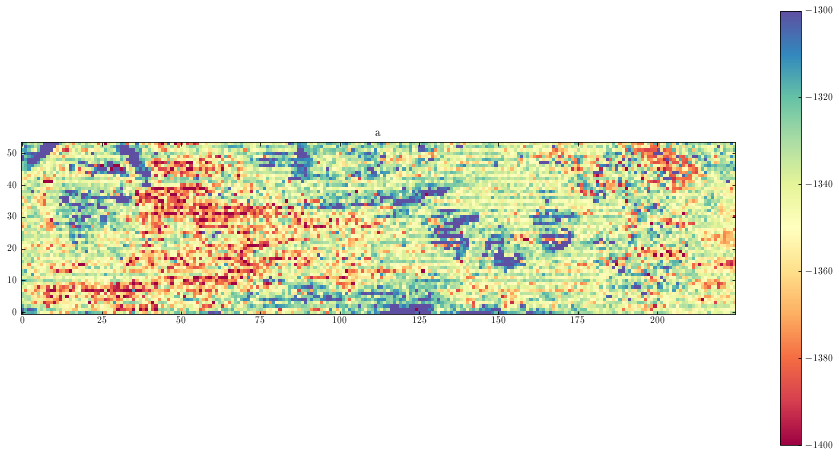

In [220]:
figure(figsize=(16,8))
title('a')
im = imshow(a,cmap='Spectral',vmin=-1400,vmax=-1300)
colorbar(im)

#### Plotting the $a,s$ dependence

There is a slight notion of a second $as$ dependence but it is weak. I have to look at it a bit more closely. The fit is not good because the linear regression does not handle well outliers.

In [246]:
opt,var = curve_fit(f_linear,a.flatten(),s.flatten())
res = least_squares(f_loss,x0=opt,args=(a.flatten(),s.flatten()),loss='cauchy')

linear_y = f_linear(a.flatten(),*opt)
cauchy_y = f_linear(a.flatten(),*res['x'])

print(opt)
print(res['x'])

[   -4.04195244 -2638.37288447]
[   -4.14937614 -2782.26594139]


Text(0, 0.5, '$s$')

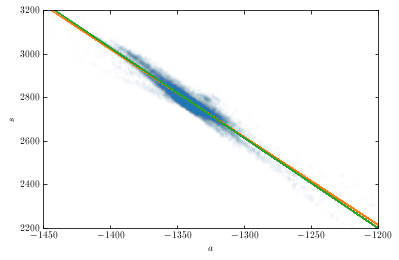

In [247]:
plot(a.flatten(),s.flatten(),'.',alpha=0.01)
xlim(-1450,-1200)
ylim(2200,3200)

plot(a.flatten(),linear_y,'--',lw=1)
plot(a.flatten(),cauchy_y,'--',lw=1)

xlabel(r'$a$')
ylabel(r'$s$')

### Loss 

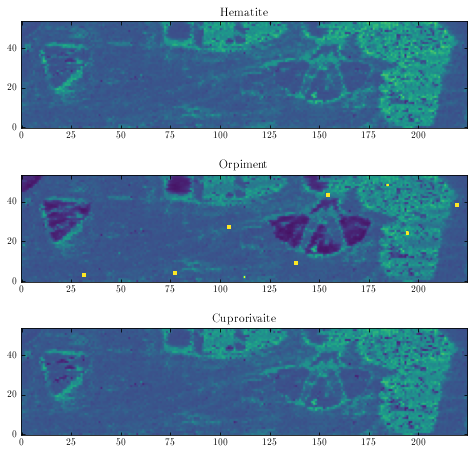

In [248]:
fig,ax = subplots(3,1,figsize=(8,8))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    ax[i].imshow(loss[:,:,i],vmin=0,vmax=0.4)

In [235]:
w1 = a.flatten()/(s.flatten()**0.5)
w2 = s.flatten()/1000

X = concatenate([[w1],[w2]],axis=0).T

In [240]:
kmeans = MiniBatchKMeans(n_clusters=3,n_init=512,batch_size=2048,max_iter=512,verbose=0).fit_predict(X)

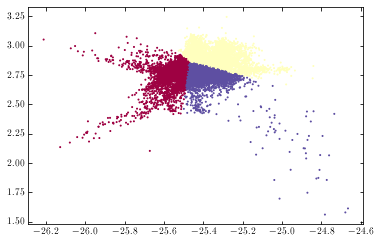

In [241]:
scatter(w1,w2,c=kmeans,s=1,cmap='Spectral')

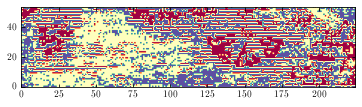

In [242]:
imshow(kmeans.reshape(a.shape[0],a.shape[1]),cmap='Spectral')